# Curious Comments 
![commentpic](comment_structure.png)

A critical part of any review are the comments. We will now proceed to analyze the comments in our q data. We will judge the predictive power of these comments, and analyze the role they play in a score's q rating.

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import os
import math
from itertools import chain
import ast

We begin by creating a dataframe of comments. We will randomly subsample 10 comments per review and only consider courses 10 or more comments. Our dataframe will consist of three columns; Comment, Course and Overall Positive Rating. A course defined to have an 'Overall Positive Rating' if it has been been given more positive ratings than negative ratings across all semesters that it has been rated.

In [3]:
MIN_PER_COURSESEM_REVIEWS = 5

In [4]:
bigdf=pd.read_csv("bigdf.csv")
bigdf.reset_index(drop=True)
bigdf.head(5)

,C_Department,C_Number,Course,C_CatNum,C_ID,C_Semester,C_Year,C_Term,C_Overall,C_Workload,C_Difficulty,C_Recommendation,C_Enrollment,C_ResponseRate,I_First,I_Last,I_ID,I_Overall,I_EffectiveLectures,I_Accessible,I_GeneratesEnthusiasm,I_EncouragesParticipation,I_UsefulFeedback,I_ReturnsAssignmentsTimely,QOverall_1,QOverall_2,QOverall_3,QOverall_4,QOverall_5,QDifficulty_1,QDifficulty_2,QDifficulty_3,QDifficulty_4,QDifficulty_5,QWorkload_1,QWorkload_2,QWorkload_3,QWorkload_4,QWorkload_5,Comments,Sem_Average,Positive
0,HISTSCI,270,HISTSCI-270,58523,2697,Spring '12,2011,2,4.67,2.33,3.33,5.00,6,50.00,Rebecca,Lemov,79de794d3e2e19eb71a2033b0ec0b76d,4.67,4.33,4.00,4.33,5.00,4.50,4.00,0,0,0,1,2,0,0,2,1,0,0,2,1,0,0,[u'This course is a perfect example of what gr...,4.226350,True
1,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '14,2014,1,4.10,7.10,NaN,3.50,13,76.92,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,4.50,4.60,3.70,3.90,3.90,4.10,4.60,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,"[u'The class has a fairly high work load, but ...",4.244370,False
2,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '13,2013,1,3.50,2.60,3.90,3.20,13,100.00,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,3.80,4.00,2.50,3.50,4.10,4.30,4.40,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,[u'Philosophy of the State with Dr. Chen offer...,4.256888,False
3,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '12,2012,1,3.73,2.47,3.67,3.47,15,100.00,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,3.87,4.33,2.64,3.93,4.18,3.64,3.82,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,[u'This was by far my favorite course. Dr. Che...,4.190299,False
4,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '11,2011,1,3.85,2.00,3.54,3.62,13,100.00,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,4.08,3.75,3.31,3.92,4.46,4.23,4.08,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,"[u'Be prepared to read', u'Discussions were gr...",4.185893,False


In [5]:
def sample_comments(commentsListAsString):
    if type(commentsListAsString) != str:
        return ""
    else:
        allComments = ast.literal_eval(commentsListAsString)
        if len(allComments) >= MIN_PER_COURSESEM_REVIEWS:
            return " ".join(np.random.choice(allComments, MIN_PER_COURSESEM_REVIEWS, replace=False))
        else:
            return ""

subdf = bigdf[['Course','C_Semester','Comments', 'Positive', 'C_Overall']].dropna()
subdf["Sampled_Comments"] = subdf.Comments.map(sample_comments)
subdf = subdf[subdf.Sampled_Comments != ""]

In [6]:
subdf.head(12)

,Course,C_Semester,Comments,Positive,C_Overall,Sampled_Comments
1,EXPOS-20.132,Fall '14,"[u'The class has a fairly high work load, but ...",False,4.10,Lot of work/reading but very rewarding. Unfort...
2,EXPOS-20.132,Fall '13,[u'Philosophy of the State with Dr. Chen offer...,False,3.50,Philosophy of the State with Dr. Chen offers m...
3,EXPOS-20.132,Fall '12,[u'This was by far my favorite course. Dr. Che...,False,3.73,"Dr. Chen starts off scary, but in the end he's..."
4,EXPOS-20.132,Fall '11,"[u'Be prepared to read', u'Discussions were gr...",False,3.85,"I truly enjoyed taking this course, and am gla..."
7,EXPOS-20.133,Spring '14,[u'This is not a bad Expos course. Dr. Chen is...,False,3.90,This class demands a high level of work if you...
13,EXPOS-20.131,Fall '14,[u'If you are interested in political philosop...,False,3.80,"I would recommend this class, the material is ..."
14,EXPOS-20.131,Fall '13,"[u'This class involves quite a bit of reading,...",False,3.60,"This class involves quite a bit of reading, bu..."
15,EXPOS-20.131,Fall '12,"[u""A basic, but thorough, understanding of phi...",False,3.86,Be prepared for a tough expos class! This is n...
16,EXPOS-20.131,Fall '11,"[u'It is a great class, which combines develop...",True,4.50,Take if you are at all interested in polysci/ ...
20,EXPOS-20.134,Spring '14,"[u""The reading material is interesting and cha...",True,4.60,The reading material is interesting and challe...


Now we will convert our comments dataframe, subdf, to a spark dataframe for text analysis

In [7]:
#setup spark
import os
import findspark
findspark.init()
print findspark.find()
import pyspark
conf = (pyspark.SparkConf()
    .setMaster('local')
    .setAppName('pyspark')
    .set("spark.executor.memory", "2g"))
sc = pyspark.SparkContext(conf=conf)
import sys
rdd = sc.parallelize(xrange(10),10)
rdd.map(lambda x: sys.version).collect()
sys.version
from pyspark.sql import SQLContext
sqlsc=SQLContext(sc)

/home/vagrant/spark


In [8]:
from pattern.en import parse
from pattern.en import pprint
from pattern.vector import stem, PORTER, LEMMA
punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')
from sklearn.feature_extraction import text 
stopwords=text.ENGLISH_STOP_WORDS
import re
regex1=re.compile(r"\.{2,}")
regex2=re.compile(r"\-{2,}")
#Useless verbs courtesy of: http://mbweston.com/2012/11/26/writing-editing-find-and-eliminate-useless-verbs/
uselessverbs = ['be','is','are','be','was','were','been','being',
                'go','goes','went','gone','going','put','puts','putting',
                'do','does','did','done','doing',
                'come','comes','came','coming',
                'have','have','has','had','having',
                'can','could','begin','begins','began','begun','beginning',
                'seem','seems','seemed','seeming',
                'get','got','gotten','getting',
                'become','became','becoming']
import re
regex1=re.compile(r"\.{2,}")
regex2=re.compile(r"\-{2,}")

We write a get parts function to parse the language in the comments. This customize get_parts function returns lists of the nouns, adjectives and verbs in the comments.

In [9]:
def get_parts(thetext):
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    nouns=[]
    descriptives=[]
    verbs = []
    for i,sentence in enumerate(parse(thetext, tokenize=True, lemmata=True).split()):
        nouns.append([])
        descriptives.append([])
        verbs.append([])
        for token in sentence:
            #print token
            if len(token[4]) >0:
                if token[1] in ['JJ', 'JJR', 'JJS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    descriptives[i].append(token[4])
                elif token[1] in ['NN', 'NNS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    nouns[i].append(token[4])
                elif token[1] in ['VB','VBP','VBZ','VBG','VBD','VBN']:
                    if token[4] in stopwords or token[4] in uselessverbs or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    verbs[i].append(token[4])
    out=zip(nouns, descriptives,verbs)
    nouns2=[]
    descriptives2=[]
    verbs2 = []
    for n,d,v in out:
        if len(n)!=0 and len(d)!=0 and len(v)!=0:
            nouns2.append(n)
            descriptives2.append(d)
            verbs2.append(v)
    return nouns2, descriptives2, verbs2

In [10]:
subdf = sqlsc.createDataFrame(subdf)
subdf = subdf['Course','C_Semester','Positive', 'C_Overall', 'Sampled_Comments']
subdf.show(5)

+------------+----------+--------+---------+--------------------+
|      Course|C_Semester|Positive|C_Overall|    Sampled_Comments|
+------------+----------+--------+---------+--------------------+
|EXPOS-20.132|  Fall '14|   false|      4.1|Lot of work/readi...|
|EXPOS-20.132|  Fall '13|   false|      3.5|Philosophy of the...|
|EXPOS-20.132|  Fall '12|   false|     3.73|Dr. Chen starts o...|
|EXPOS-20.132|  Fall '11|   false|     3.85|I truly enjoyed t...|
|EXPOS-20.133|Spring '14|   false|      3.9|This class demand...|
+------------+----------+--------+---------+--------------------+
only showing top 5 rows



In [11]:
comment_parts = subdf.rdd.map(lambda r: get_parts(r.Sampled_Comments))
comment_parts.take(1)

[([[u'course'],
   [u'subject', u'course', u'overall', u'expectation'],
   [u'purpose',
    u'class',
    u'freshman',
    u'writing',
    u'skill',
    u'class',
    u'resource',
    u'purpose'],
   [u'work', u'effort', u'essay'],
   [u'essay', u'topic', u'guidance'],
   [u'feedback', u'draft', u'draft'],
   [u'feedback', u'office', u'hour'],
   [u'peer', u'resource', u'guidance', u'class'],
   [u'class', u'requirement'],
   [u'lot', u'grader'],
   [u'lot', u'work', u'summary', u'assignment']],
  [[u'unlikely'],
   [u'passionate'],
   [u'useful'],
   [u'manageable'],
   [u'reasonable', u'little'],
   [u'vague', u'unhelpful', u'final'],
   [u'difficult', u'constructive', u'accessible'],
   [u'writing'],
   [u'particular'],
   [u'hard'],
   [u'prepared', u'dense', u'philosophical', u'online']],
  [[u'recommend'],
   [u'meet'],
   [u'educate', u'provide', u'fulfill'],
   [u'relate'],
   [u'provide'],
   [u'provide'],
   [u'ask'],
   [u'obtain'],
   [u'recommend', u'fulfill'],
   [u'read'

In [12]:
%%time
parsedcomments=comment_parts.collect()

CPU times: user 166 ms, sys: 36.3 ms, total: 203 ms
Wall time: 1min 25s


We begin our text analysis with an LDA of the nouns in the comments 

In [13]:
[e[0] for e in parsedcomments[:3]]

[[[u'course'],
  [u'subject', u'course', u'overall', u'expectation'],
  [u'purpose',
   u'class',
   u'freshman',
   u'writing',
   u'skill',
   u'class',
   u'resource',
   u'purpose'],
  [u'work', u'effort', u'essay'],
  [u'essay', u'topic', u'guidance'],
  [u'feedback', u'draft', u'draft'],
  [u'feedback', u'office', u'hour'],
  [u'peer', u'resource', u'guidance', u'class'],
  [u'class', u'requirement'],
  [u'lot', u'grader'],
  [u'lot', u'work', u'summary', u'assignment']],
 [[u'philosophy',
   u'stimulating',
   u'class',
   u'discussion',
   u'variety',
   u'topic',
   u'student',
   u'share'],
  [u'class', u'discussion', u'class', u'lot', u'philosophy'],
  [u'philosophy', u'state', u'class', u'writing', u'essay', u'college'],
  [u'matter', u'society'],
  [u'deal',
   u'philosophy',
   u'writing',
   u'focus',
   u'philosophy',
   u'writing',
   u'writing',
   u'class'],
  [u'philosophy',
   u'state',
   u'discussion',
   u'struggle',
   u'balance',
   u'nature',
   u'society',
 

In [14]:
ldadatardd=sc.parallelize([ele[0] for ele in parsedcomments]).flatMap(lambda l: l)
ldadatardd.cache()
ldadatardd.take(5)

[[u'course'],
 [u'subject', u'course', u'overall', u'expectation'],
 [u'purpose',
  u'class',
  u'freshman',
  u'writing',
  u'skill',
  u'class',
  u'resource',
  u'purpose'],
 [u'work', u'effort', u'essay'],
 [u'essay', u'topic', u'guidance']]

In [15]:
ldadatardd.flatMap(lambda word: word).take(5)

[u'course', u'subject', u'course', u'overall', u'expectation']

In [16]:
vocabtups = (ldadatardd.flatMap(lambda word: word)
             .map(lambda word: (word, 1))
             .reduceByKey(lambda a, b: a + b)
             .map(lambda (x,y): x)
             .zipWithIndex()
).cache()

In [17]:
vocab=vocabtups.collectAsMap()
id2word=vocabtups.map(lambda (x,y): (y,x)).collectAsMap()

In [18]:
id2word[0], vocab.keys()[5], vocab[vocab.keys()[5]]

(u'similarity', u'sleep', 7)

In [19]:
len(vocab.keys())

4296

In [20]:
from collections import defaultdict
def helperfunction(element):
    d = defaultdict(int)
    for k in element:
        d[vocab[k]] += 1
    return d.items()
documents = ldadatardd.map(lambda w: helperfunction(w))

In [21]:
documents.take(5)

[[(1289, 1)],
 [(1584, 1), (569, 1), (3745, 1), (1289, 1)],
 [(4267, 2), (1326, 1), (1523, 1), (4020, 1), (277, 1), (3387, 2)],
 [(1082, 1), (1188, 1), (3150, 1)],
 [(514, 1), (3340, 1), (3150, 1)]]

In [22]:
corpus=documents.collect()

In [23]:
import gensim

In [24]:
lda2 = gensim.models.ldamodel.LdaModel(corpus = corpus, num_topics = 2, id2word=id2word, chunksize=200, passes = 10)

Above, we print the topics we find using LDA.

In [25]:
lda2.print_topics()

[(0,
  u'0.162*class + 0.052*lot + 0.040*time + 0.031*way + 0.030*work + 0.020*fun + 0.019*material + 0.019*professor + 0.018*person + 0.017*language'),
 (1,
  u'0.119*course + 0.028*lecture + 0.019*topic + 0.017*material + 0.016*experience + 0.015*student + 0.015*problem + 0.014*research + 0.013*history + 0.012*project')]

The first topic (let us call this Topic 0) includes the combination of words: 

- class, lot, time, work, way, professor, problem, section, exam, and fun.


The second topic (let us call this Topic 1) includes the following combination of words: 

- course, material, lecture, student, topic, reading, person, science, year, and lecturer.


Topic 0 seems to encompass the more interactive, qualitative, personable aspects of the course with key terms including class, professor, problem, section, and fun. Topic 1, by contrast, seems to encompass the more solitary, logistical, factual aspects of a course that a student experiences with key terms including material, lecture, student, topic, reading, year, and lecturer. One thing worth noticing is that Topic 1 includes "course" as a key term while Topic 0 includes "class". While "course" and "class" are often used interchangably in language, "class" arguably connotes a more personal, interactive experience than "course", which is more administrative and logistical and more likely to be used as an umbrella term for everything from everyday class to homework. This would support our separation of Topic 0 and 1 into more interactive/personable aspects and more logistical/solitary aspects, respectively.

In order to further evaluate our intial hypothesis that course reviews are split along two topics (interactive, qualitiative, personable aspects v. solitary, logistical aspects), we will output the words of some sentences, along with the probability of the sentence belonging to Topic 0 and Topic 1, to qualitatively check that our topics are reasonable and supported.

In [26]:
for bow in corpus[0:1200:60]:
    print bow
    print lda2.get_document_topics(bow)
    print " ".join([id2word[e[0]] for e in bow])
    print "=========================================="

[(1289, 1)]
[(0, 0.25000470052176144), (1, 0.74999529947823862)]
course
[(1227, 1), (1941, 1)]
[(0, 0.5047871735862689), (1, 0.49521282641373121)]
discussion addition
[(449, 1)]
[(0, 0.74996198087494292), (1, 0.25003801912505702)]
person
[(595, 1)]
[(0, 0.74965928031126094), (1, 0.250340719688739)]
news
[(1864, 1), (1057, 1), (3539, 1), (1960, 1)]
[(0, 0.87651856039511489), (1, 0.12348143960488511)]
piece artwork critiquing cent
[(2920, 1), (4267, 1), (277, 1), (1007, 1)]
[(0, 0.89996997243619903), (1, 0.10003002756380099)]
bit class writing time
[(3823, 1)]
[(0, 0.25002530255311534), (1, 0.74997469744688472)]
problem
[(4267, 1), (1797, 1)]
[(0, 0.50040329578697229), (1, 0.49959670421302765)]
class model
[(914, 1), (4267, 1), (436, 1), (3991, 1)]
[(0, 0.89991163819882869), (1, 0.10008836180117123)]
way class mind thought
[(1082, 1), (4267, 1), (1013, 1)]
[(0, 0.62558362036909521), (1, 0.37441637963090479)]
work class concept
[(1289, 1), (2411, 1), (1013, 1), (2169, 1), (3393, 1)]
[(0, 

The "sentences" (or bag-of-words) which have a much greater probability of belonging to Topic 0 include:
- class writer load work
- class bit pass work
- class cost intervention u'very benefit reform lot issue
- class student success belief stand risk course question ability
- class kink
- way professor class discussion material
- food professor person class
- class section discussion student
- time homework week

The words in these sentences are more descriptive and relate to more creative, interactive, person-to-person aspects of a course. Specifically, "writer", "intervention", "reform", "issue", "success", "belief", "stand", "risk", "question", "kink", and "discussion" all imply rich and diverse elements of the course experience. As a Harvard student, I know that the word "section" also implies discussion and collaboration since sections for Harvard classes provide an opportunity outside of lecture to engage more closely with course material and consist of tight-knit groups.


The "setences" which have a much greater probability of belonging to Topic 1 include:
- concept background
- reading
- thought-provoking discussion debate material staff teaching

The function below transforms X-col (which consists of word-based "sentences" (bag-of-words or "documents")) using the vectorizer which is also a parameter.
- time bit course u"must
- career course regret
- education perspective lot debate history

Words in these sentences that are not present in the previous cluster of setences and that stand out as implying more impersonal, logistical, or practical aspects of a course include "concept", "background", "reading", "material", "time", "must", "education", "history", and arguably "staff" (since "staff" is a somewhat impersonal way to refer to professors and teaching fellows). Although words like "thought-provoking", "discussion", "debate" and "teaching" do appear, it is worthwhile to note that the sentence/bag-of-words in which they appear still has a relatively high probability of belonging to Topic 0 (~35%).

The "sentences" which have more equal probabilities of belonging to Topic 0 or 1 include:
- time assignment philosophy night
- course lot
- chance education course lot style
- student reason
- way class overview study

For sentences/bag-of-words with relatively equal probabilities of belonging to Topic 0 and Topic 1, we can observe both words implying more interactive, creative aspects ("philosophy", "style", "student", "reason") and words implying more logistical aspects ("time", "assignment", "overview", "study").


From our analysis of the topic probabilities and bag-of-words above, there appears to be evidence to support our initial hypothesis that course reviews are split along two topics: Topic 0, which includes more interactive, qualitative, personable aspects of a course, and Topic 1, which includes more solitary, logistical aspects.

TO DOs:
- We can consider doing "verbs" (use TextBlob)
- Detect "not" before adjectives, this shouldn't be too difficult
- Text before pushing
- Look at differences across departments (Jesse/Andrew)


Let us now continue with a sentiment analysis of the adjectives in the comments using Naive Bayes. We begin by extracting the adjectives as we did before with the nouns. 

In [27]:
nbdatardd=sc.parallelize([ele[1] for ele in parsedcomments])
nbdatardd.cache()
nbdatardd.take(3)

[[[u'unlikely'],
  [u'passionate'],
  [u'useful'],
  [u'manageable'],
  [u'reasonable', u'little'],
  [u'vague', u'unhelpful', u'final'],
  [u'difficult', u'constructive', u'accessible'],
  [u'writing'],
  [u'particular'],
  [u'hard'],
  [u'prepared', u'dense', u'philosophical', u'online']],
 [[u'wide', u'fellow', u'similar'],
  [u'interesting', u'willing', u'interesting'],
  [u'difficult', u'better'],
  [u'subject', u'interesting'],
  [u'great', u'political', u'different'],
  [u'awesome']],
 [[u'scary'],
  [u'heavy', u'interesting'],
  [u'interesting', u'discussed', u'interesting', u'detailed'],
  [u'political', u'acceptable'],
  [u'great'],
  [u'idiosyncratic', u'broader', u'academic'],
  [u'excellent'],
  [u'large', u'outside', u'classic'],
  [u'reading', u'interesting'],
  [u'expos', u'interesting', u'great'],
  [u'great', u'greatest']]]

In [28]:
adjvocabtups = (nbdatardd.flatMap(lambda l: l).flatMap(lambda word: word)
             .map(lambda word: (word, 1))
             .reduceByKey(lambda a, b: a + b)
             .map(lambda (x,y): x)
             .zipWithIndex()
).cache()
adjvocab=adjvocabtups.collectAsMap()

In [29]:
len(adjvocab)

3070

Now we need to flatten the all of the adjectives for a particular semester of comments of a course into a single document and then make an array of these documents for get our adjective "features" and retrieve our response array, comprised of the positive column of our subdf, as this is the response variable we are trying to predict. The length of these two arrays should be equal if we do this correctly

In [30]:
import itertools
Xarraypre=nbdatardd.map(lambda l: " ".join(list(itertools.chain.from_iterable(l))))
Xarray=Xarraypre.collect()
resparray = subdf.rdd.map(lambda r: r.Positive).collect()

In [31]:
len(Xarray), len(resparray)

(3256, 3256)

Next we use mask to create a train and test split.

In [32]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(len(Xarray)), train_size=0.7)
mask=np.ones(len(Xarray), dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

We then transform the adjectives into a bag of words representation and use a vectorizer to create a feature and write some support functions for Naive Bayes analysis. 

In [33]:
def make_xy(X_col, y_col, vectorizer):
    X = vectorizer.fit_transform(X_col)
    y = y_col
    return X, y

We plan on using log-likelyhood as a scoring metric and write a support function to be able to do so

In [34]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    negatives = y == False
    positives = ~negatives
    return prob[negatives, False].sum() + prob[positives, True].sum()

We define a function to estimate the cross-validated score (given a classifier, data, and a scoring function).

In [35]:
from sklearn.cross_validation import KFold

def cv_score(clf, x, y, score_func, nfold=5):
    """
    Uses 5-fold cross validation to estimate a score of a classifier
    
    Inputs
    ------
    clf : Classifier object
    x : Input feature vector
    y : Input class labels
    score_func : Function like log_likelihood, that takes (clf, x, y) as input,
                 and returns a score
                 
    Returns
    -------
    The average score obtained by splitting (x, y) into 5 folds of training and 
    test sets, fitting on the training set, and evaluating score_func on the test set
    
    Examples
    cv_score(clf, x, y, log_likelihood)
    """
    result = 0
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf, x[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We also define a usseful function for visualizing the calibration of a probabilistic classifier (in order to recognize whether our classifier is over-confident or under-confident).

In [36]:
def calibration_plot(clf, xtest, ytest):
    prob = clf.predict_proba(xtest)[:, 1]
    outcome = ytest
    data = pd.DataFrame(dict(prob=prob, outcome=outcome))

    #group outcomes into bins of similar probability
    bins = np.linspace(0, 1, 20)
    cuts = pd.cut(prob, bins)
    binwidth = bins[1] - bins[0]
    
    #freshness ratio and number of examples in each bin
    cal = data.groupby(cuts).outcome.agg(['mean', 'count'])
    cal['pmid'] = (bins[:-1] + bins[1:]) / 2
    cal['sig'] = np.sqrt(cal.pmid * (1 - cal.pmid) / cal['count'])
        
    #the calibration plot
    ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    p = plt.errorbar(cal.pmid, cal['mean'], cal['sig'])
    plt.plot(cal.pmid, cal.pmid, linestyle='--', lw=1, color='k')
    plt.ylabel("Empirical P(+)")
    
    #the distribution of P(+)
    ax = plt.subplot2grid((3, 1), (2, 0), sharex=ax)
    
    plt.bar(left=cal.pmid - binwidth / 2, height=cal['count'],
            width=.95 * (bins[1] - bins[0]),
            fc=p[0].get_color())
    
    plt.xlabel("Predicted P(+)")
    plt.ylabel("Number")

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

We convert Xarray and Resparray into numpy arrays for use with sklearn

In [38]:
X=np.array(Xarray)
y=np.array(resparray)

Now we write a cross-validation loop to find the best hyper-parameters for our Naive Bayes analysis.

In [39]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(vocabulary = adjvocab, min_df = min_df)       
        Xthis, ythis = make_xy(X, y, vectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        clf = MultinomialNB(alpha=alpha)
        cvscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
        if cvscore > maxscore:
            maxscore = cvscore
            best_alpha, best_min_df = alpha, min_df

In [40]:
print "alpha: %f" % best_alpha
print "min_df: %f" % best_min_df

alpha: 50.000000
min_df: 0.000010


Now that we have determined the best parameters, we are ready to run the Naive Bayes classifier and create a calibration plot. 

Accuracy on training data: 0.71
Accuracy on test data:     0.66


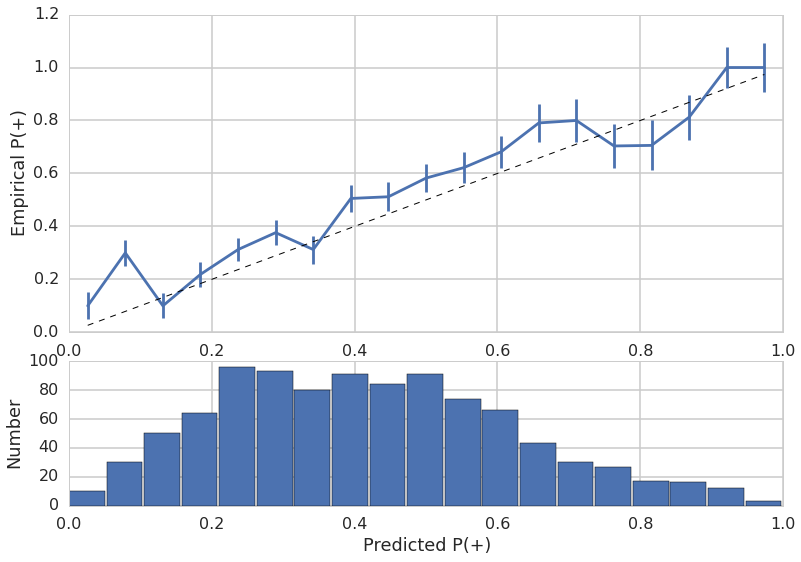

In [41]:
vectorizer = CountVectorizer(vocabulary = adjvocab, min_df=best_min_df)
X2, y2 = make_xy(X, y, vectorizer)
xtrain=X2[mask]
ytrain=y2[mask]
xtest=X2[~mask]
ytest=y2[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

# Your code here. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)
calibration_plot(clf, xtest, ytest)

In [42]:
nbdatardd_verbs=sc.parallelize([ele[2] for ele in parsedcomments])
nbdatardd_verbs.cache()
nbdatardd_verbs.take(3)

[[[u'recommend'],
  [u'meet'],
  [u'educate', u'provide', u'fulfill'],
  [u'relate'],
  [u'provide'],
  [u'provide'],
  [u'ask'],
  [u'obtain'],
  [u'recommend', u'fulfill'],
  [u'read'],
  [u'read', u'post', u'work']],
 [[u'offer', u'cover'],
  [u'read', u'frustrate'],
  [u'make'],
  [u'make', u'think', u'live'],
  [u'learn', u'feel', u'improve', u'improve', u'improve'],
  [u'say', u'enjoy']],
 [[u'start'],
  [u'exclude', u'hate'],
  [u'depend', u'review', u'read'],
  [u'like'],
  [u'focuse'],
  [u'write', u'involve', u'look', u'choose'],
  [u'well-learn'],
  [u'expect', u'devote', u'read', u'prepare', u'contribute'],
  [u'look', u'recommend'],
  [u'require'],
  [u'look']]]

In [43]:
verbvocabtups = (nbdatardd_verbs.flatMap(lambda l: l).flatMap(lambda word: word)
             .map(lambda word: (word, 1))
             .reduceByKey(lambda a, b: a + b)
             .map(lambda (x,y): x)
             .zipWithIndex()
).cache()
verbvocab=verbvocabtups.collectAsMap()

In [44]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(vocabulary = verbvocab, min_df = min_df)       
        Xthis, ythis = make_xy(X, y, vectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        clf = MultinomialNB(alpha=alpha)
        cvscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
        if cvscore > maxscore:
            maxscore = cvscore
            best_alpha, best_min_df = alpha, min_df

In [45]:
print "alpha: %f" % best_alpha
print "min_df: %f" % best_min_df

alpha: 50.000000
min_df: 0.000010


Accuracy on training data: 0.62
Accuracy on test data:     0.62


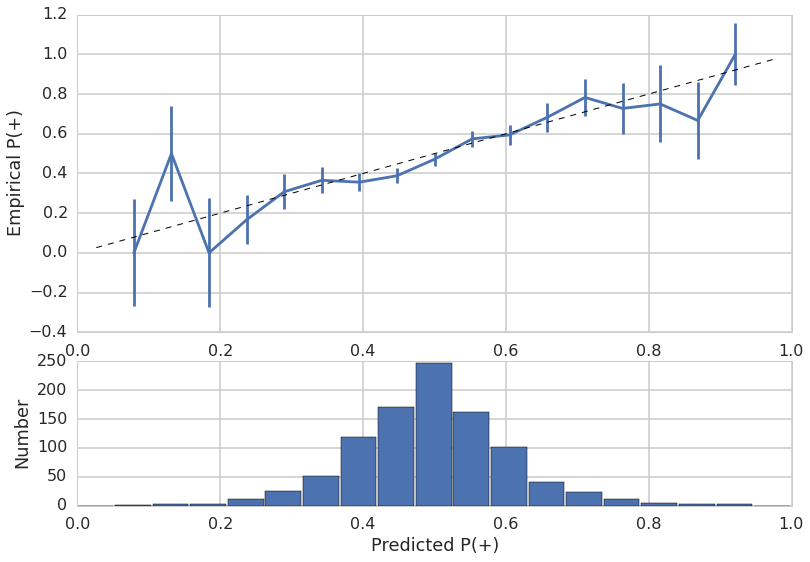

In [46]:
vectorizer = CountVectorizer(vocabulary = verbvocab, min_df=best_min_df)
X2, y2 = make_xy(X, y, vectorizer)
xtrain=X2[mask]
ytrain=y2[mask]
xtest=X2[~mask]
ytest=y2[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

# Your code here. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)
calibration_plot(clf, xtest, ytest)

Explain...

Now we will proceed to combine our LDA with our Naive Bayes analysis for both adjectives and verbs and calculate to get a idea of the extent to which comments can give us idea of whether a course was rated positively or not.

As we have learned from our text analysis that adjectives provide the most useful information in distinguishing positive reviews from negative ones, let us proceed to observe what descriptives are generally found in the q comments of the best rated courses and the worst rated courses to get an idea of what words describe the best and worst courses at Harvard according to q scores. We begin by creating a subdf2, a spark data frame derived from this dataframe that we can use for this type of text analysis.

We begin this process by making two dataframes, Pos_df and Neg_df, which are essentially just dataframes of the positively and negatively rated courses as defined by our criteria that positively rated courses are those that have an overall Q score higher than the average overall Q of the semester in which the rating was given and negatively rated reviews are those with an overall Q score lower than the average overall Q of the semester. Let us sample the top 10% of the positively rated courses to get an idea of the desriptives in the comments of the best q reviews and sample the bottom 10% of the negatively rated courses to get an idea of descriptives in the worst q reviews. To do so, we sort Posdf in descending order and Negdf in ascending order, and then obtain the top and bottom 10%. 

In [98]:
Posdf = subdf[subdf['Positive'] == True]
PosNum = Posdf.count()
Top10 = int(0.1 * PosNum)
Posdf = Posdf.rdd.sortBy(lambda x: x.C_Overall, ascending = False)
Posdf = sqlsc.createDataFrame(Posdf.take(Top10))
Negdf = subdf[subdf['Positive'] == False]
NegNum = Negdf.count()
Bottom10 = int(0.1 * NegNum)
Negdf = Negdf.rdd.sortBy(lambda x: x.C_Overall)
Negdf = sqlsc.createDataFrame(Negdf.take(Bottom10))

Now we extract the adjectives in the positive and negative reviews. 

In [99]:
%%time
Positive_comment_parts = Posdf.rdd.map(lambda r: get_parts(r.Sampled_Comments)).collect()
Negative_comment_parts = Negdf.rdd.map(lambda r: get_parts(r.Sampled_Comments)).collect()

CPU times: user 27.1 ms, sys: 20.2 ms, total: 47.3 ms
Wall time: 12.4 s


Let us take a look at the sample of the adjectives in the negatively rated courses and positively rated courses.

In [100]:
negativeadjrdd=sc.parallelize([ele[1] for ele in Negative_comment_parts])
negativeadjrdd.cache()
negativeadjrdd.take(3)

[[[u'mcb'],
  [u'easy', u'relative', u'difficult'],
  [u'chem', u'199', u'high', u'interesting'],
  [u'best'],
  [u'worst'],
  [u'wrong', u'main']],
 [[u'independent'],
  [u'productive'],
  [u'long',
   u'easy',
   u'short',
   u'sure',
   u'1-page',
   u'new',
   u'good',
   u'challenging'],
  [u'fifth'],
  [u'nelc'],
  [u'clear', u'second'],
  [u'different', u'future'],
  [u'meaningful'],
  [u'arabic-english'],
  [u'good'],
  [u'constant', u'new'],
  [u'useful', u'beneficial'],
  [u'new', u'difficult'],
  [u'new', u'clear'],
  [u'short', u'fictional', u'following', u'dense', u'dry'],
  [u'read', u'unrelated', u'real'],
  [u'accurate'],
  [u'impossible'],
  [u'difficult', u'long', u'dominated'],
  [u'difficult', u'complete'],
  [u'average', u'frustrated'],
  [u'unreasonable', u'impossible'],
  [u'gain', u'able']],
 [[u'nonexistent', u'right'],
  [u'final', u'final', u'late'],
  [u'additional', u'electrical'],
  [u'independent']]]

In [101]:
positiveadjrdd=sc.parallelize([ele[1] for ele in Positive_comment_parts])
positiveadjrdd.cache()
positiveadjrdd.take(3)

[[[u'relevant'],
  [u'bad', u'great', u'great'],
  [u'math', u'major', u'great'],
  [u'fantastic', u'interesting', u'best'],
  [u'constructive', u'accessible'],
  [u'best'],
  [u'amazing'],
  [u'fair', u'logistical', u'super', u'helpful'],
  [u'fascinating'],
  [u'fantastic'],
  [u'enjoyable', u'helpful']],
 [[u'prepared', u'hard', u'ready', u'transformative'],
  [u'prepared', u'20-40'],
  [u'advanced', u'interesting', u'great', u'chinese'],
  [u'difficult']],
 [[u'important', u'american', u'foreign'],
  [u'foreign', u'american'],
  [u'interesting', u'interesting', u'foreign'],
  [u'cool', u'exciting'],
  [u'fascinating'],
  [u'fascinating', u'great', u'successful', u'foreign']]]

Let us now retrieve the top 20 descriptives for the negatively rated and positively rated reviews using some flattening and a spark word count algorithm. We can also create wordle visualizations to help us better observe the distinctions between the descriptives of positively and negatively rated words.

In [102]:
Top_Neg_Adj = (negativeadjrdd.flatMap(lambda l: l).flatMap(lambda word: word)
               .map(lambda w: (w, 1))
               .reduceByKey(lambda x, y: x + y)
               .collect())
Sorted_Neg_Adj = sorted(Top_Neg_Adj, key=lambda tup: tup[1], reverse=True)
Sorted_Neg_Adj[:20]

[(u'interesting', 90),
 (u'good', 85),
 (u'great', 57),
 (u'difficult', 57),
 (u'interested', 39),
 (u'useful', 33),
 (u'little', 30),
 (u'final', 30),
 (u'easy', 29),
 (u'new', 21),
 (u'different', 21),
 (u'sure', 20),
 (u'helpful', 20),
 (u'important', 19),
 (u'prepared', 18),
 (u'better', 17),
 (u'hard', 16),
 (u'able', 14),
 (u'disorganized', 13),
 (u'molecular', 12)]

In [103]:
Top_Pos_Adj = (positiveadjrdd.flatMap(lambda l: l).flatMap(lambda word: word)
               .map(lambda w: (w, 1))
               .reduceByKey(lambda x, y: x + y)
               .collect())
Sorted_Pos_Adj = sorted(Top_Pos_Adj, key=lambda tup: tup[1], reverse=True)
Sorted_Pos_Adj[:20]

[(u'great', 134),
 (u'interesting', 59),
 (u'amazing', 44),
 (u'best', 44),
 (u'interested', 43),
 (u'wonderful', 33),
 (u'good', 33),
 (u'able', 31),
 (u'difficult', 25),
 (u'incredible', 25),
 (u'helpful', 25),
 (u'sure', 23),
 (u'fantastic', 22),
 (u'different', 21),
 (u'willing', 20),
 (u'better', 20),
 (u'new', 19),
 (u'excellent', 18),
 (u'awesome', 18),
 (u'fascinating', 17)]